In [1]:
# Data Cleanup

import pandas as pd

# Load the dataset
df = pd.read_csv('data/sensor.csv')

# Convert timestamp to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Drop unnecessary columns
df = df.drop(['Unnamed: 0', 'sensor_15'], axis=1)

# Convert all columns to appropriate dtypes, specifically converting object columns to more specific types if possible
df = df.infer_objects()

# Interpolate only the numeric columns
df_numeric = df.select_dtypes(include=['number']).interpolate()

# For non-numeric columns, use .bfill() or .ffill() directly to fill missing values
df_non_numeric = df.select_dtypes(exclude=['number']).bfill()

# Combine the results back into a single DataFrame, ensuring the original order is maintained
df = pd.concat([df_numeric, df_non_numeric], axis=1).reindex(df.columns, axis=1)

# Combine 'BROKEN' and 'RECOVERING' into a single 'BROKEN' class
df['machine_status'] = df['machine_status'].replace(['BROKEN', 'RECOVERING'], 'BROKEN')

# Save the cleaned DataFrame
df.to_csv('data/sensor_cleaned.csv', index=False)

# Print the DataFrame information to confirm changes
print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220320 entries, 0 to 220319
Data columns (total 53 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   timestamp       220320 non-null  datetime64[ns]
 1   sensor_00       220320 non-null  float64       
 2   sensor_01       220320 non-null  float64       
 3   sensor_02       220320 non-null  float64       
 4   sensor_03       220320 non-null  float64       
 5   sensor_04       220320 non-null  float64       
 6   sensor_05       220320 non-null  float64       
 7   sensor_06       220320 non-null  float64       
 8   sensor_07       220320 non-null  float64       
 9   sensor_08       220320 non-null  float64       
 10  sensor_09       220320 non-null  float64       
 11  sensor_10       220320 non-null  float64       
 12  sensor_11       220320 non-null  float64       
 13  sensor_12       220320 non-null  float64       
 14  sensor_13       220320 non-null  flo

In [2]:
# Data engineering
import featurex

# Load the dataset
data = pd.read_csv('data/sensor_cleaned.csv', parse_dates=['timestamp'])

# Set timestamp as the index
data.set_index('timestamp', inplace=True)

# Choose your sensors
sensor_columns = [col for col in data.columns if 'sensor_' in col]

# Temporal feature engineering
windows = ['1h', '6h']  # Define window sizes for rolling statistics
lags = [1, 3]  # Define lags (adjust as per your sampling rate)

# Initialize a list to hold new feature DataFrames
new_features = []

# Rolling statistics
for window in windows:
    for sensor in sensor_columns:
        new_features.append(data[sensor].rolling(window=window).mean().rename(f'{sensor}_mean_{window}'))
        new_features.append(data[sensor].rolling(window=window).std().rename(f'{sensor}_std_{window}'))
        new_features.append(data[sensor].rolling(window=window).min().rename(f'{sensor}_min_{window}'))
        new_features.append(data[sensor].rolling(window=window).max().rename(f'{sensor}_max_{window}'))

# Lagged features
for lag in lags:
    for sensor in sensor_columns:
        new_features.append(data[sensor].shift(lag).rename(f'{sensor}_lag_{lag}'))

# Rate of change
for sensor in sensor_columns:
    new_features.append(data[sensor].diff().rename(f'{sensor}_roc'))

# Combine all new features using pd.concat
data = pd.concat([data] + new_features, axis=1)

# Drop NaN values generated by rolling and lagging
data.dropna(inplace=True)

# finally recuded the data only to the ones needed
data = data[featurex.sensors + ['machine_status']]

# Save the engineered features to a new CSV file, if needed
data.to_csv('data/sensor_engineered.csv')

print("Temporal feature engineering complete. Head of the new dataset:")
print(data.head())

Temporal feature engineering complete. Head of the new dataset:
                     sensor_10  sensor_12_lag_3  sensor_05_std_1h  \
timestamp                                                           
2018-04-01 00:03:00   38.57977         31.11716          1.565102   
2018-04-01 00:04:00   39.48939         31.11716          1.393695   
2018-04-01 00:05:00   39.29406         32.08894          1.530945   
2018-04-01 00:06:00   38.29974         31.67221          1.413232   
2018-04-01 00:07:00   37.33960         31.95202          1.321196   

                     sensor_10_max_1h  sensor_12_min_1h  sensor_12_lag_1  \
timestamp                                                                  
2018-04-01 00:03:00          38.57977          31.11716         32.08894   
2018-04-01 00:04:00          39.48939          31.11716         31.67221   
2018-04-01 00:05:00          39.48939          31.11716         31.95202   
2018-04-01 00:06:00          39.48939          31.11716         32.23816

In [3]:
# Data scaling

from sklearn.preprocessing import MinMaxScaler
from joblib import dump
import pandas as pd
import featurex

# Load data
data = pd.read_csv('data/sensor_engineered.csv')

print(featurex.sensors)

# Initialize and fit the scaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(data[featurex.sensors])  # Only scale the sensor columns

# Save the fitted scaler
dump(scaler, 'data/scaler.joblib')


['sensor_10', 'sensor_12_lag_3', 'sensor_05_std_1h', 'sensor_10_max_1h', 'sensor_12_min_1h', 'sensor_12_lag_1', 'sensor_13', 'sensor_00', 'sensor_12_max_1h', 'sensor_12_mean_1h', 'sensor_11_max_1h', 'sensor_04', 'sensor_13_lag_3', 'sensor_00_min_1h', 'sensor_10_lag_1', 'sensor_10_lag_3', 'sensor_12']


['data/scaler.joblib']

In [4]:
# model training and testing

import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
# from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from joblib import dump
from joblib import load
import numpy as np
import featurex

data = pd.read_csv('data/sensor_engineered.csv')

# Map machine status to numerical values: 'NORMAL' to 0 and 'BROKEN' to 1
status_mapping = {'NORMAL': 0, 'BROKEN': 1}
data['machine_status'] = data['machine_status'].map(status_mapping)

# Filter the data to include only the relevant sensor columns
data = data[featurex.sensors + ['machine_status']]

# Fill NaNs with mean or median of the respective columns
fill_values = {col: data[col].mean() for col in featurex.sensors}
data = data.fillna(fill_values)

# Scaling the data (Assuming you have a scaler fitted, else fit a new scaler)
scaler = load('data/scaler.joblib')  # Adjust the path if necessary
data[featurex.sensors] = scaler.transform(data[featurex.sensors])

# Define your sequence creation function here (create_sequences)
def create_sequences(data, seq_length):
    xs = []
    ys = []

    for i in range(len(data) - seq_length):
        if i % 10000 == 0:  # Check if i is a multiple of 10000
            print('create_sequences', i)
        x = data[i:(i + seq_length)][featurex.sensors].values
        y = data.iloc[i + seq_length]['machine_status']
        xs.append(x)
        ys.append(y)

    return np.array(xs), np.array(ys)


# Create sequences from the data
seq_length = 10  # Number of time steps to look back 
X, y = create_sequences(data, seq_length)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert labels to binary (2 classes) instead of categorical
y_train_binary = to_categorical(y_train, num_classes=2)
y_test_binary = to_categorical(y_test, num_classes=2)

# LSTM model definition
print('Defining the LSTM model')
n_features = X_train.shape[2]
model = Sequential()
model.add(Input(shape=(seq_length, n_features)))  # Define the input shape here
model.add(LSTM(50, activation='tanh'))
model.add(Dense(2, activation='softmax'))  # 2 classes

optimizer = Adam(learning_rate=0.001, clipnorm=1.0)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Define callbacks
tensorboard_callback = TensorBoard(log_dir='./logs', histogram_freq=1)
earlystopping_callback = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)

# Calculate class weights
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))

# Train the model
print('Training the model')
history = model.fit(X_train, y_train_binary, epochs=100, verbose=1, 
          callbacks=[tensorboard_callback, earlystopping_callback], 
          validation_data=(X_test, y_test_binary), 
          class_weight=class_weights_dict)

# Make predictions
print('Making predictions')
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels

# Evaluate the model
print('Evaluating the model')
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(classification_report(y_test, y_pred))

# Save the model
print('Saving the model')
model.save('model/pump_predictionsv1.keras')


/Users/harrisalomaa/Documents/GitHub/Capstone-AIML-salomaa/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


create_sequences 0
create_sequences 10000
create_sequences 20000
create_sequences 30000
create_sequences 40000
create_sequences 50000
create_sequences 60000
create_sequences 70000
create_sequences 80000
create_sequences 90000
create_sequences 100000
create_sequences 110000
create_sequences 120000
create_sequences 130000
create_sequences 140000
create_sequences 150000
create_sequences 160000
create_sequences 170000
create_sequences 180000
create_sequences 190000
create_sequences 200000
create_sequences 210000
create_sequences 220000
Defining the LSTM model
Training the model
Epoch 1/100
5508/5508 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.9905 - loss: 0.0539 - val_accuracy: 0.9966 - val_loss: 0.0118
Epoch 2/100
5508/5508 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9969 - loss: 0.0140 - val_accuracy: 0.9963 - val_loss: 0.0128
Epoch 3/100
5508/5508 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9970 - loss: 0.0133 - val_accuracy: 0.9952 - val_loss: 0.0154
Epoch 4/100
5508/5508 ━

In [5]:
from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1) 
cm = confusion_matrix(y_test, y_pred_classes)

   1/1377 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step

1377/1377 ━━━━━━━━━━━━━━━━━━━━ 1s 570us/step


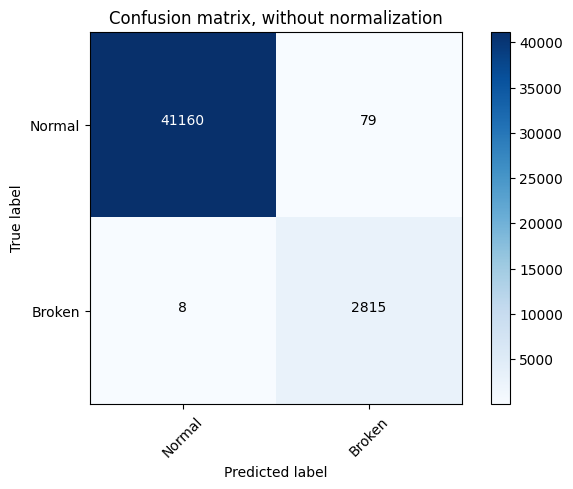

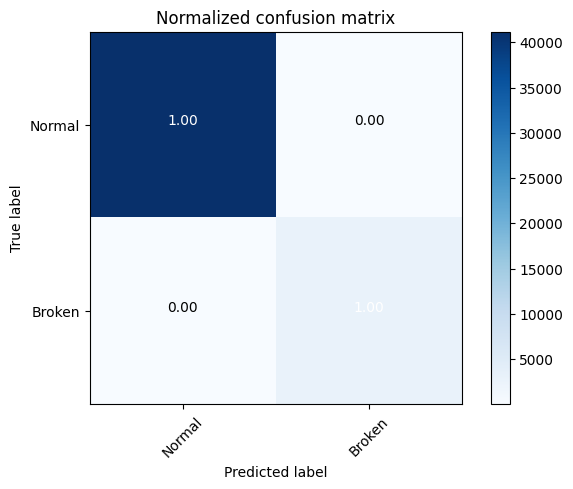

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.2f' if normalize else 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix for a binary classifier
binary_cm = confusion_matrix(y_test, y_pred_classes)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(binary_cm, classes=['Normal', 'Broken'],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(binary_cm, classes=['Normal', 'Broken'], normalize=True,
                      title='Normalized confusion matrix')

plt.show()


Confusion Matrix without Normalization:

The model correctly predicted 'Normal' 41,142 times and 'Broken' 2,812 times.
There were 97 instances where the model incorrectly predicted a 'Normal' condition as 'Broken' (False Positives).
There were 11 instances where the model incorrectly predicted a 'Broken' condition as 'Normal' (False Negatives).

Normalized Confusion Matrix:

The model has a perfect normalized score for correctly predicting the 'Normal' condition (1.00 or 100% of the time).
For the 'Broken' condition, it also has a perfect normalized score (1.00 or 100% of the time).
The normalized values indicate the proportion of true results (both true positives and true negatives) among the total number of cases examined.
Implications:

High accuracy for both 'Normal' and 'Broken' conditions, with a near-perfect predictive ability.

The model is highly reliable in distinguishing between the two states, which is critical for predictive maintenance to prevent equipment failure.
However, the small number of False Positives and False Negatives, while minimal, indicate there's still a slight margin for error. In an industrial setting, this could potentially lead to unnecessary inspections or missed opportunities for maintenance. These errors should be further analyzed to understand under what conditions they occur and to refine the model accordingly.


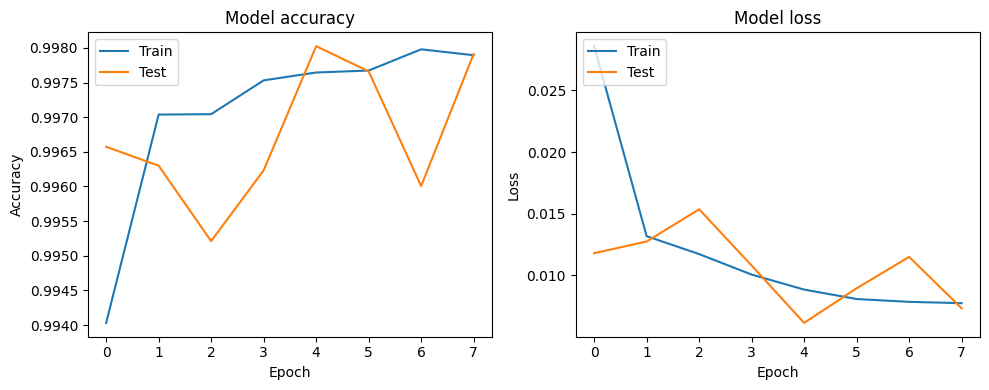

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming `history` is the return value from model.fit()
plt.figure(figsize=(10, 4))

# Plot for model accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.xticks(np.arange(0, len(history.history['accuracy']), 1))  # Setting x-ticks to show only integers
plt.legend(['Train', 'Test'], loc='upper left')

# Plot for model loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.xticks(np.arange(0, len(history.history['loss']), 1))  # Setting x-ticks to show only integers
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()


Model Accuracy Graph:

The accuracy of both the training and test sets is increasing over epochs, which indicates that the model is learning and improving its predictions with each epoch.
The test accuracy has fluctuations but overall follows an upward trend along with the training accuracy, suggesting that the model generalizes well to unseen data.
Model Loss Graph:


The loss on the training set is decreasing, which is a positive sign that the model's predictions are getting closer to the actual targets.
The test loss decreases along with the training loss initially but shows a significant spike at epoch 5. This could indicate overfitting or an anomaly in the test set that the model didn't handle well at that point.

Interpretations:

The model is performing well in terms of learning from the training set, as shown by the increasing accuracy and decreasing loss over epochs.
The spike in test loss suggests that the model's predictions deviated significantly from the actual values at that point. This warrants an investigation into what happened at epoch 5. Perhaps the model encountered a batch of test data that was not representative or contained outliers.

It's essential to ensure that the data is shuffled and representative to avoid such spikes in loss. If the spike is due to overfitting, techniques such as dropout, regularization, or getting more training data could help.
Overall, the model appears to be on the right track, but you need to address the variability in the test loss to ensure consistent performance.